# Optimal acceptance thresholds

<div class="alert alert-warning">
Note: The SilkOptimalEpsilon threshold schedule is work in progress and may or may not work. Contact us if you are interested.
</div>

In [1]:
# install if not done yet
#!pip install pyabc[autograd] --quiet

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import logging

import pyabc
pyabc.settings.set_figure_params("pyabc")  # for beautified plots

# debug
for debugger in ["ABC.Distance", "ABC.Epsilon"]:
    logging.getLogger("ABC.Distance").setLevel(logging.DEBUG)

## Issues of quantile-based acceptance thresholds

Approximate Bayesian Computation with a Sequential Monte Carlo scheme (ABC-SMC) generates a sequence of populations constituting sequentially better posterior approximations
$$\pi_{\text{ABC},\varepsilon}(\theta|y_\text{obs}) \propto \int I[d(y,y_\text{obs})\leq\varepsilon]\pi(y|\theta)\pi(\theta)\operatorname{dy},$$
corresponding to reduced acceptance thresholds $\varepsilon$. Under mild conditions, the ABC posterior converges to the true Bayesian posterior for $\varepsilon\rightarrow 0$, i.e.
$$\pi_{\text{ABC},\varepsilon}(\theta|y_\text{obs})\rightarrow\pi(\theta|y_\text{obs}).$$
(Note that the use of insufficient summary statistics adds another layer of approximation, which we abstract from here.)

However, in practice $\varepsilon\rightarrow 0$ is not guaranteed, or rather small-enough levels are not known, raising the question of how to determine the sequence of thresholds $\{\varepsilon_t\}$.
Often, values are pre-defined (`ListEpsion`), which is however overall impractical, as it requires manual tuning of at least the initial threshold can yield excessively low or high acceptance rates.
A common strategy is to set the threshold of generation $t$ as a quantile of the (weighted) distances $\{d_i=d(y_i,y_\text{obs})\}_{i\leq N}$ accepted in generation $t-1$. However, such an approach may fail to focus on small domains of attraction. Consider the following (deterministic) example, discussed in [Silk et al. 2012](https://arxiv.org/pdf/1210.3296.pdf), which possesses a wide local optimum and a small global optimum:

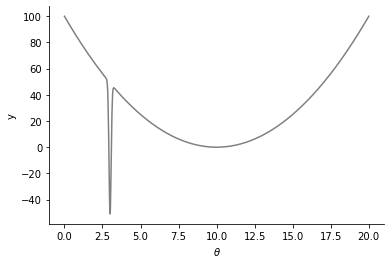

In [3]:
def model(p):
    theta = p["theta"]
    return {"y": (theta - 10)**2 - 100 * np.exp(-100 * (theta - 3)**2)}

p_true = {"theta": 3}
y_obs = model(p_true)

bounds = {"theta": (0, 20)}
prior = pyabc.Distribution(
    **{key: pyabc.RV("uniform", lb, ub-lb) for key, (lb, ub) in bounds.items()}
)

# plot observables over parameters
_, ax = plt.subplots()
xs = np.linspace(0, 20, 1000)
ys = model({"theta": xs})["y"]
ax.plot(xs, ys, color="grey")
ax.set_xlabel(r"$\theta$")
ax.set_ylabel("y");

Some more utilities:

In [4]:
pop_size = 200
n_samples = pop_size * 20
db_path = pyabc.create_sqlite_db_id()

def plot_posterior(history, show_history=False, ax=None):
    """Plot 1d posteriors."""
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 6))
    t0 = 0
    if not show_history:
        t0 = history.max_t
    for t in range(t0, history.max_t + 1):
        df, w = history.get_distribution(t=t)
        pyabc.visualization.plot_kde_1d(
            df, w, xmin=bounds["theta"][0], xmax=bounds["theta"][1],
            numx=1000,
            x="theta", ax=ax,
            label=f"t={t}" if show_history else None,
            refval=p_true, refval_color="grey",
            kde=pyabc.GridSearchCV(),
        )
    
def plot_pars_over_data(history):
    """Plot parameters over data background."""
    _, ax = plt.subplots(figsize=(10, 6))
    ax.plot(xs, ys - y_obs["y"], color="grey")
    for t in range(history.max_t + 1):
        df, _ = history.get_distribution(t=t)
        eps = history.get_all_populations().set_index("t").loc[t, "epsilon"]
        ax.plot(
            df["theta"], eps * np.ones_like(df["theta"]), ".", markersize=1,
            color=pyabc.visualization.colors.RED900,
        )
    ax.set_xlabel(r"$\theta$")
    ax.set_ylabel(r"$d(y,y_ {obs})$")

Let us first try a quantile-based threshold strategy:

In [5]:
abc = pyabc.ABCSMC(
    model, prior, pyabc.PNormDistance(p=2),
    population_size=pop_size,
    eps=pyabc.QuantileEpsilon(alpha=0.8),
)

abc.new(db_path, y_obs)

h = abc.run(max_total_nr_simulations=n_samples)

ABC.Sampler INFO: Parallelize sampling on 4 processes.
ABC.History INFO: Start <ABCSMC id=71, start_time=2022-01-03 22:16:24>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 1.17996036e+02.
ABC INFO: Accepted: 200 / 243 = 8.2305e-01, ESS: 2.0000e+02.
ABC INFO: t: 1, eps: 8.94684070e+01.
ABC INFO: Accepted: 200 / 274 = 7.2993e-01, ESS: 1.9770e+02.
ABC INFO: t: 2, eps: 7.45631259e+01.
ABC INFO: Accepted: 200 / 265 = 7.5472e-01, ESS: 1.9785e+02.
ABC INFO: t: 3, eps: 6.53487815e+01.
ABC INFO: Accepted: 200 / 255 = 7.8431e-01, ESS: 1.9631e+02.
ABC INFO: t: 4, eps: 5.95414433e+01.
ABC INFO: Accepted: 200 / 254 = 7.8740e-01, ESS: 1.9776e+02.
ABC INFO: t: 5, eps: 5.60461722e+01.
ABC INFO: Accepted: 200 / 268 = 7.4627e-01, ESS: 1.9529e+02.
ABC INFO: t: 6, eps: 5.41734380e+01.
ABC INFO: Accepted: 200 / 240 = 8.3333e-01, ESS: 1.9907e+02.
ABC INFO: t: 7, eps: 5.27513345e+01.
ABC INFO: Accepted: 200 / 268 = 7.4627e-01, ESS: 1.9831e+02.
ABC INFO: t: 8, eps: 5.21412598e+01.
ABC INFO: Accept

The posterior should converge to a point estimate at $\theta=3$, however when repeating the above analysis, in many cases does not do so, but converges to a bimodal distribution, or one with a single mode at $\theta=10$.
This is because the majority of samples is from the local optimum, such that a focus on a small subset is required to push the sample towards the global mode.

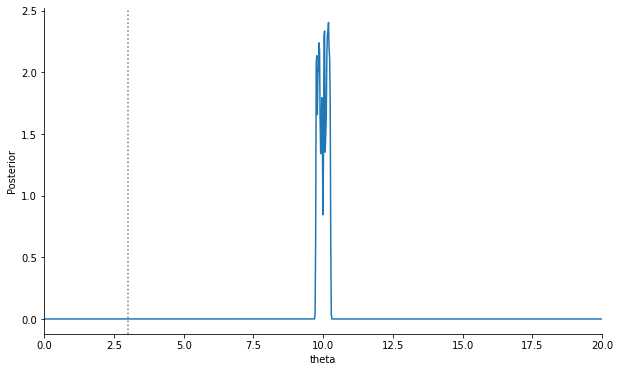

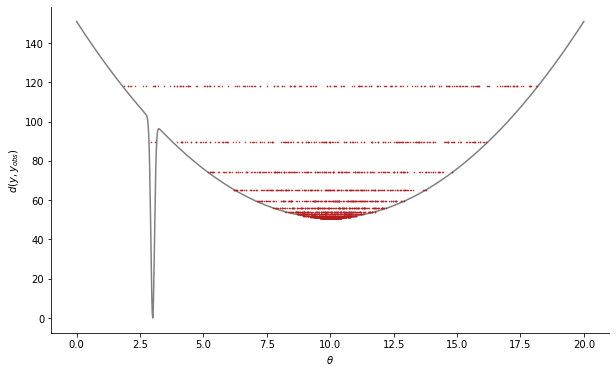

In [6]:
plot_posterior(h)
plot_pars_over_data(h);

As observed in Silk et al., for large quantile values, the chance of completely missing the global optimum increases, which can be explained by more populations being generated until a similar point is reached, each providing an opportunity to miss the global optimum (and from there on ever after with high probability).
This can be circumvented by a lower quantile, which increases the focus on the global optimum. Upon repetition, this analysis is less likely to solely focus on the local optimum, and more likely to correctly only sample from the global one.

ABC.Sampler INFO: Parallelize sampling on 4 processes.
INFO:ABC.Sampler:Parallelize sampling on 4 processes.
ABC.History INFO: Start <ABCSMC id=72, start_time=2022-01-03 22:16:39>
INFO:ABC.History:Start <ABCSMC id=72, start_time=2022-01-03 22:16:39>
ABC INFO: Calibration sample t = -1.
INFO:ABC:Calibration sample t = -1.
ABC INFO: t: 0, eps: 6.56681192e+01.
INFO:ABC:t: 0, eps: 6.56681192e+01.
ABC INFO: Accepted: 200 / 512 = 3.9062e-01, ESS: 2.0000e+02.
INFO:ABC:Accepted: 200 / 512 = 3.9062e-01, ESS: 2.0000e+02.
ABC INFO: t: 1, eps: 5.34805033e+01.
INFO:ABC:t: 1, eps: 5.34805033e+01.
ABC INFO: Accepted: 200 / 575 = 3.4783e-01, ESS: 1.1893e+02.
INFO:ABC:Accepted: 200 / 575 = 3.4783e-01, ESS: 1.1893e+02.
ABC INFO: t: 2, eps: 5.12722427e+01.
INFO:ABC:t: 2, eps: 5.12722427e+01.
ABC INFO: Accepted: 200 / 657 = 3.0441e-01, ESS: 9.1626e+01.
INFO:ABC:Accepted: 200 / 657 = 3.0441e-01, ESS: 9.1626e+01.
ABC INFO: t: 3, eps: 5.10100882e+01.
INFO:ABC:t: 3, eps: 5.10100882e+01.
ABC INFO: Accepted: 20

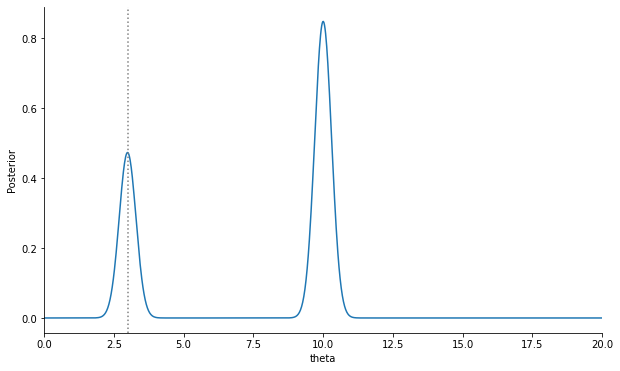

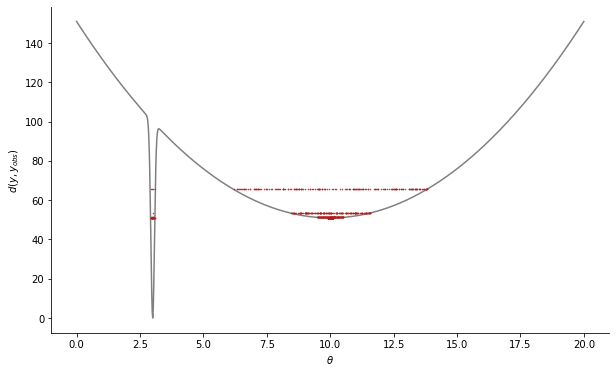

In [7]:
# smaller alpha

abc = pyabc.ABCSMC(
    model, prior, pyabc.PNormDistance(p=2),
    population_size=pop_size,
    eps=pyabc.QuantileEpsilon(alpha=0.4),
)

abc.new(db_path, y_obs)

h = abc.run(max_total_nr_simulations=n_samples)

plot_posterior(h);
plot_pars_over_data(h);

ABC.Sampler INFO: Parallelize sampling on 4 processes.
INFO:ABC.Sampler:Parallelize sampling on 4 processes.
ABC.History INFO: Start <ABCSMC id=73, start_time=2022-01-03 22:16:46>
INFO:ABC.History:Start <ABCSMC id=73, start_time=2022-01-03 22:16:46>
ABC INFO: Calibration sample t = -1.
INFO:ABC:Calibration sample t = -1.
ABC INFO: t: 0, eps: 5.42237530e+01.
INFO:ABC:t: 0, eps: 5.42237530e+01.
ABC INFO: Accepted: 200 / 1106 = 1.8083e-01, ESS: 2.0000e+02.
INFO:ABC:Accepted: 200 / 1106 = 1.8083e-01, ESS: 2.0000e+02.
ABC INFO: t: 1, eps: 5.10957963e+01.
INFO:ABC:t: 1, eps: 5.10957963e+01.
ABC INFO: Accepted: 200 / 1114 = 1.7953e-01, ESS: 1.2050e+02.
INFO:ABC:Accepted: 200 / 1114 = 1.7953e-01, ESS: 1.2050e+02.
ABC INFO: t: 2, eps: 5.10009543e+01.
INFO:ABC:t: 2, eps: 5.10009543e+01.
ABC INFO: Accepted: 200 / 6297 = 3.1761e-02, ESS: 8.6278e+01.
INFO:ABC:Accepted: 200 / 6297 = 3.1761e-02, ESS: 8.6278e+01.
ABC INFO: Stop: Total simulations budget.
INFO:ABC:Stop: Total simulations budget.
ABC.Hi

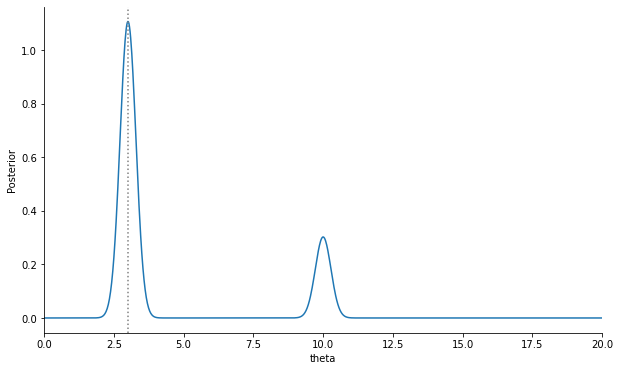

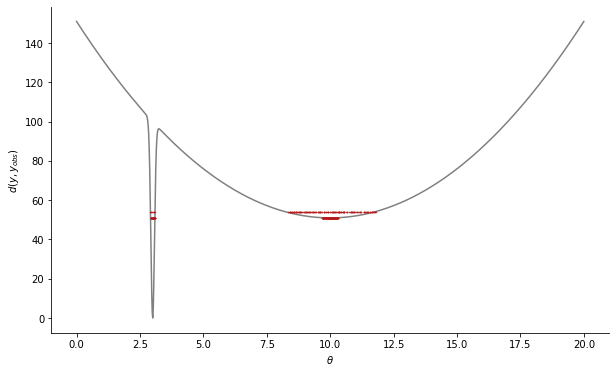

In [8]:
# even smaller alpha

abc = pyabc.ABCSMC(
    model, prior, pyabc.PNormDistance(p=2),
    population_size=pop_size,
    eps=pyabc.QuantileEpsilon(alpha=0.2),
)

abc.new(db_path, y_obs)

h = abc.run(max_total_nr_simulations=n_samples)

plot_posterior(h);
plot_pars_over_data(h);

## Optimal threshold based on predicting the acceptance rate

In general, an appropriate quantile in situations as sketeched above, as well as a sufficiently large population size, are problem-dependent. Silk et al. thus propose a strategy that tries to identify the problem of local optima and propose appropriate values automatically. It does so by predicting the acceptance rate in the next population as a function of the threshold. In the first place, it then chooses a threshold maximizing the Hessian of that function, yielding appropriate values for convex shapes, indicative of local optima. If such potential problems cannot be found (i.e. the function is mostly concave), instead a threshold is chosen as a trade-off of acceptance rate and threshold decrease, minimizing a combined objective. See the paper or the API documentation for further details.

In pyABC, the `SilkOptimalEpsilon` is based on the above-mentioned approach:

ABC.Sampler INFO: Parallelize sampling on 4 processes.
INFO:ABC.Sampler:Parallelize sampling on 4 processes.
ABC.History INFO: Start <ABCSMC id=74, start_time=2022-01-03 22:16:53>
INFO:ABC.History:Start <ABCSMC id=74, start_time=2022-01-03 22:16:53>
ABC INFO: Calibration sample t = -1.
INFO:ABC:Calibration sample t = -1.
ABC.Epsilon INFO: Optimal threshold for t=0: eps=1.2204e+02, estimated rate=8.3779e-01 (discontinuous=8.6000e-01)
INFO:ABC.Epsilon:Optimal threshold for t=0: eps=1.2204e+02, estimated rate=8.3779e-01 (discontinuous=8.6000e-01)
ABC.Population INFO: Recording also rejected particles: True
INFO:ABC.Population:Recording also rejected particles: True
ABC INFO: t: 0, eps: 1.22038280e+02.
INFO:ABC:t: 0, eps: 1.22038280e+02.
ABC INFO: Accepted: 200 / 262 = 7.6336e-01, ESS: 2.0000e+02.
INFO:ABC:Accepted: 200 / 262 = 7.6336e-01, ESS: 2.0000e+02.
ABC.Epsilon INFO: Optimal threshold for t=1: eps=4.4794e+01, estimated rate=6.1656e-02 (discontinuous=7.7688e-03)
INFO:ABC.Epsilon:Opti

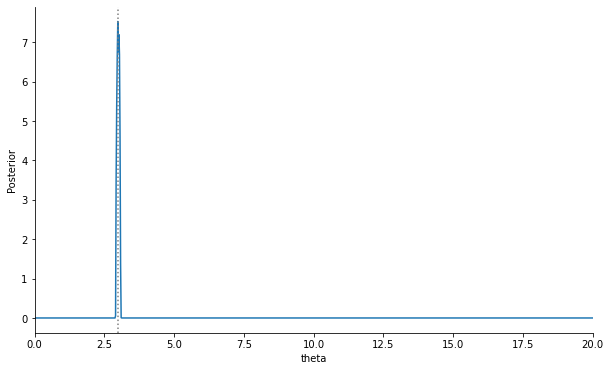

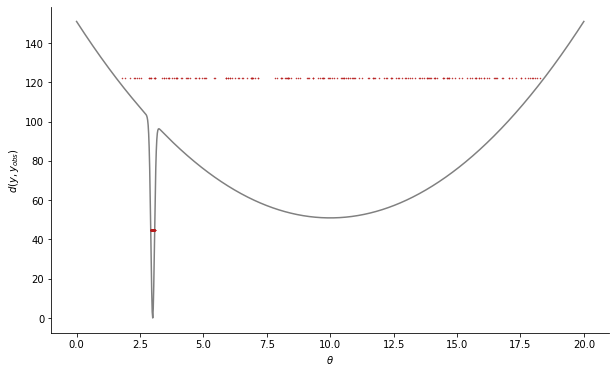

In [9]:
abc = pyabc.ABCSMC(
    model, prior, pyabc.PNormDistance(p=2),
    population_size=pop_size,
    eps=pyabc.SilkOptimalEpsilon(k=10)
)

abc.new(db_path, y_obs)

h = abc.run(max_total_nr_simulations=n_samples)

plot_posterior(h)
plot_pars_over_data(h);

This approach more or less reliably converges to the global minimum.

Note that this threshold method may suffer from deteriorating acceptance rates and may thus perform inferior to quantile based thresholds on problems where the latter are applicable. The `SilkOptimalEpsilon` can be also be combined with adaptive distances.

So, when to use such advanced threshold strategies? For most low-dimensional problems, a simple quantile-based strategy may be sufficient. However, as seen above, especially in the presence of local optima, approaches such as the above one may be necessary. At the least, carefully checking the analysis, e.g. examining low-distance particles, may generally be a good idea.